# Xarray Genetics API Prototype 

In [5]:
# Set to enable auto-complete for subclass properties
# See: https://github.com/ipython/ipython/issues/11653#issuecomment-492578777
%config Completer.use_jedi = False
import sys
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
sys.path.append(".")
from lib import api
xr.set_options(display_style='html')

In [3]:
# 10 variants, 5 samples, and 2 chromosomes for which hard calls are simulated
shape = (10, 5, 2)

In [6]:
# From numpy:
gt = np.random.randint(0, 2, size=shape, dtype=np.uint8) # Draw from [0, 1]
gt = api.GenotypeCallDataset(gt, attrs={'description': 'Bi-allelic, diploid hard call array example [numpy]'})
gt.data

<xarray.DataArray 'data' (variant: 10, sample: 5, ploidy: 2)>
array([[[0, 0],
        [1, 1],
        [1, 0],
        [0, 1],
        [0, 0]],

       [[1, 0],
        [0, 1],
        [1, 1],
        [0, 0],
        [1, 1]],

       [[0, 0],
        [1, 0],
        [0, 1],
        [0, 0],
        [0, 1]],

       [[0, 0],
        [1, 1],
        [1, 0],
        [0, 0],
        [0, 1]],

       [[0, 1],
        [1, 1],
        [1, 1],
        [1, 0],
        [1, 0]],

       [[0, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 1],
        [0, 0],
        [1, 0],
        [1, 0],
        [0, 1]],

       [[1, 0],
        [1, 1],
        [1, 1],
        [1, 0],
        [1, 1]],

       [[0, 1],
        [0, 0],
        [1, 1],
        [0, 1],
        [1, 0]],

       [[1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 1]]], dtype=uint8)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4
  * ploidy   (ploidy) int64 0 1
Attributes:
    description:  Bi-allelic, diploid hard call array example [numpy]

In [5]:
gt.to_count_dataset()

<xarray.GenotypeCountDataset>
Dimensions:  (sample: 5, variant: 10)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4
Data variables:
    data     (variant, sample) uint64 2 1 1 2 1 2 1 0 1 1 ... 1 2 2 1 1 2 2 0 1
Attributes:
    description:  Bi-allelic, diploid hard call array example [numpy]

## Data Structures

Data structure classes are all ```xarray.Dataset``` subclasses and do not maintain any state that will interfere with serialization or other Xarray functionality.  They function solely to:

- Provide casting mechanisms from one type to another (e.g. array containing allele index by chromosome to array containing alt allele counts)
- Apply preconditions on underlying arrays (e.g. count arrays have to be some unsigned integer type, all others will raise an error)
  - This allows for the data model to do most of the upfront type, value, and shape checking that many functions might otherwise do with a bunch of biolerplate.  In other words, this shifts data structure validation to the type hint system rather than "utility" functions.
- Allow pass-through support for duck array typing, meaning that this library should make as few assumptions as possible about what underlying array libraries are used (e.g. numpy, dask, xarray).  Anything implementing [\_\_array_function__](https://numpy.org/neps/nep-0018-array-function-protocol.html) is fine.
- Serve as anchors for documentation.

Any information that is specific to a genetics dataset needs to be represented in xarray Attributes, as coordinates, or as data variables in a Dataset -- no instance attributes should be attached to the class instances directly.  Examples of this are phasing and masking.  These are both stored alongside call, probability, and count arrays as separate data variables within one ```xarray.Dataset```.

### Creating Datasets

In [7]:
# 10 variants, 5 samples, and 2 chromosomes for which hard calls are simulated
shape = (10, 5, 2)

In [8]:
# From numpy:
gt = np.random.randint(0, 2, size=shape, dtype=np.uint8) # Draw from [0, 1] where 0 = ref allele and 1 = alt allele 
gt = api.GenotypeCallDataset(gt, attrs={'description': 'Bi-allelic, diploid hard call array example [numpy]'})
gt

<xarray.GenotypeCallDataset>
Dimensions:  (ploidy: 2, sample: 5, variant: 10)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4
  * ploidy   (ploidy) int64 0 1
Data variables:
    data     (variant, sample, ploidy) uint8 1 0 1 0 1 0 1 0 ... 1 0 0 1 1 1 0 0
Attributes:
    description:  Bi-allelic, diploid hard call array example [numpy]

In [9]:
# From dask, with phase information:
gt = da.random.randint(0, 2, size=shape, dtype=np.uint8)
ip = da.random.randint(0, 2, size=shape).astype(bool) # Simulate phasing per call
gt = api.GenotypeCallDataset(data=gt, phased=ip, attrs={'description': 'Bi-allelic, diploid hard call array example [dask]'})
gt

<xarray.GenotypeCallDataset>
Dimensions:  (ploidy: 2, sample: 5, variant: 10)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4
  * ploidy   (ploidy) int64 0 1
Data variables:
    data     (variant, sample, ploidy) uint8 dask.array<chunksize=(10, 5, 2), meta=np.ndarray>
    phased   (variant, sample, ploidy) bool dask.array<chunksize=(10, 5, 2), meta=np.ndarray>
Attributes:
    description:  Bi-allelic, diploid hard call array example [dask]

In [10]:
gt.data.data

dask.array<randint, shape=(10, 5, 2), dtype=uint8, chunksize=(10, 5, 2), chunktype=numpy.ndarray>

In [11]:
# From xarray (gt is already has an Xarray DataArray in `.data` attribute)
api.GenotypeCallDataset(gt.data)

<xarray.GenotypeCallDataset>
Dimensions:  (ploidy: 2, sample: 5, variant: 10)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4
  * ploidy   (ploidy) int64 0 1
Data variables:
    data     (variant, sample, ploidy) uint8 dask.array<chunksize=(10, 5, 2), meta=np.ndarray>

To represent more complex structures, such as CNV data for a multi-allelic, polyploid experiment, multiple arrays can be used if a single array representation is either inefficient or impossible.  For example, it would be possible to represent CNV data as a 4D array with shape ```(variants, samples, ploidy, allele)``` where individual values correspond to allele count on one chrosome.  This may be very inefficient though if the size of the ```allele``` dimension is much larger than the size of the ```ploidy``` dimension (e.g. supporting up to say 5 alleles with a ploidy of 2 means at least 3 zeros will be present in every vector along the last dimension).  The allele index and counts can be maintained separately to avoid this:

In [25]:
# Create an array containing hard calls where values correspond to allele index (up to at most 5 alleles possible in this case)
gt_idx = np.random.randint(0, 5, size=shape, dtype=np.uint8)

# Create an array containing the copy numbers as counts of the alleles above on each chromosome
gt_cts = np.random.randint(0, 10, size=shape, dtype=np.uint8)

# Combine the two arrays into a single dataset
gt_cnv = api.GenotypeAlleleCountDataset(gt_cts, gt_idx, attrs={'name': 'CNV Dataset Example (data = allele count, indexes = allele index)'})
gt_cnv

<xarray.GenotypeAlleleCountDataset>
Dimensions:  (ploidy: 2, sample: 5, variant: 10)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4
  * ploidy   (ploidy) int64 0 1
Data variables:
    data     (variant, sample, ploidy) uint8 4 5 2 6 6 0 5 7 ... 2 1 2 5 1 6 5 7
    indexes  (variant, sample, ploidy) uint8 2 0 1 2 0 0 0 4 ... 4 1 4 3 3 3 0 1
Attributes:
    name:     CNV Dataset Example (data = allele count, indexes = allele index)

### Data Structure Conversions

The API facilitates conversions to different representations where possible through methods on the data structure subclasses.  These conversions often result in a loss of information (e.g. reductions across a dimension) -- i.e. they are not invertible.  This makes it easy for an analysis to start with a complex N-dimensional structure and call these conversions where needed as inputs to algorithms that generally expect simpler structures (e.g. LD estimation only needs alternate allele counts as a 2D array).

These examples show a few common conversions:

#### Hard Calls to Alt Allele Counts

In [40]:
# Simulate an array of diploid, multi-allelic hard calls
gt = np.random.randint(0, 3, size=shape, dtype=np.uint8) # Draw from [0, 2]
gt = api.GenotypeCallDataset(gt, attrs={'description': 'Calculating alt allele count from hard calls'})
gt

<xarray.GenotypeCallDataset>
Dimensions:  (ploidy: 2, sample: 5, variant: 10)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4
  * ploidy   (ploidy) int64 0 1
Data variables:
    data     (variant, sample, ploidy) uint8 1 2 1 0 0 0 1 1 ... 0 2 2 0 1 1 1 0
Attributes:
    description:  Calculating alt allele count from hard calls

In [41]:
# Convert to number of alternate alleles across all chromosomes for each variant + sample combination
ct = gt.to_count_dataset()
ct

<xarray.GenotypeCountDataset>
Dimensions:  (sample: 5, variant: 10)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4
Data variables:
    data     (variant, sample) int64 2 1 0 2 1 1 0 2 2 2 ... 1 2 1 2 1 2 1 1 2 1
Attributes:
    description:  Calculating alt allele count from hard calls

In [42]:
# This is the usual input many genetics methods operate on
ct.data.to_pandas()

sample,0,1,2,3,4
variant,,,,,
0,2,1,0,2,1
1,1,0,2,2,2
2,0,2,1,2,1
3,1,1,2,1,2
4,2,1,1,1,2
5,1,1,2,2,1
6,1,2,2,2,1
7,0,2,1,1,0
8,1,2,1,2,1


In [43]:
# Ignoring masks, the above is the same as this (but w/o API type preservation):
(gt.data > 0).sum(dim='ploidy')

<xarray.DataArray 'data' (variant: 10, sample: 5)>
array([[2, 1, 0, 2, 1],
       [1, 0, 2, 2, 2],
       [0, 2, 1, 2, 1],
       [1, 1, 2, 1, 2],
       [2, 1, 1, 1, 2],
       [1, 1, 2, 2, 1],
       [1, 2, 2, 2, 1],
       [0, 2, 1, 1, 0],
       [1, 2, 1, 2, 1],
       [2, 1, 1, 2, 1]])
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4

#### Probabilities to Dosage

If the genotype calls for an experiment are imputed (or probabilistic for some other reason), this is what converting to dosage looks like:

In [62]:
# Simulate allele probability array with dims (variant, sample, ploidy, allele)
gp = np.random.rand(1000, 100, 2, 2)
# Convert random values to probabilities so that the sum of values across alleles is 1
gp /= gp.sum(axis=-1, keepdims=True)
gp.shape

(1000, 100, 2, 2)

In [63]:
# Show a single vector of allele probabilities for one variant + sample + chromosome
gp[0, 0, 0]

array([0.53901138, 0.46098862])

In [64]:
gp = api.GenotypeProbabilityDataset(gp, attrs={'description': 'Genotype probability example'})
gp

<xarray.GenotypeProbabilityDataset>
Dimensions:  (allele: 2, ploidy: 2, sample: 100, variant: 1000)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * sample   (sample) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * ploidy   (ploidy) int64 0 1
  * allele   (allele) int64 0 1
Data variables:
    data     (variant, sample, ploidy, allele) float64 0.539 0.461 ... 0.2312
Attributes:
    description:  Genotype probability example

In [65]:
# Dosages will be calculated as Pr(Heterozygous) + 2 * Pr(Homozygous Alternate) (Allele 0 assumed as reference)
gpd = gp.to_dosage_dataset()
gpd

<xarray.GenotypeDosageDataset>
Dimensions:  (sample: 100, variant: 1000)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * sample   (sample) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
    allele   int64 1
Data variables:
    data     (variant, sample) float64 0.9669 0.8608 0.5938 ... 1.153 1.066
Attributes:
    description:  Genotype probability example

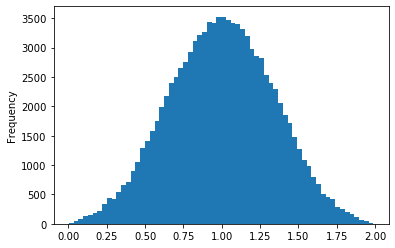

In [66]:
# Show histogram of dosage values in [0, 2]
gpd.data.to_pandas().stack().plot(kind='hist', bins=64)

### Missing Data

In [15]:
shape = (8, 4)
ht = da.ma.masked_array(
    # Genotype calls (in [0, 1])
    np.random.randint(0, 2, size=shape, dtype=np.int8), 
    # Mask values are True or False where True indicates missing
    np.random.choice([False, True], size=shape, p=[.8, .2])
)
ht = api.HaplotypeCallDataset(ht)
ht

<xarray.HaplotypeCallDataset>
Dimensions:  (sample: 4, variant: 8)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7
  * sample   (sample) int64 0 1 2 3
Data variables:
    data     (variant, sample) int8 dask.array<chunksize=(8, 4), meta=np.ndarray>
    mask     (variant, sample) bool dask.array<chunksize=(8, 4), meta=np.ndarray>

In [29]:
ht.data.to_pandas().assign(nasum=(ht.data * ~ht.mask).sum(dim='sample').to_pandas())

sample,0,1,2,3,nasum
variant,,,,,
0,1,-1,1,0,2
1,-1,0,1,1,2
2,1,1,0,-1,2
3,0,1,1,1,3
4,1,-1,0,-1,1
5,1,1,0,0,2
6,0,1,1,-1,2
7,1,0,1,1,3


In [20]:
ht.mask.to_pandas()

sample,0,1,2,3
variant,,,,
0,False,True,False,False
1,True,False,False,False
2,False,False,False,True
3,False,False,False,False
4,False,True,False,True
5,False,False,False,False
6,False,False,False,True
7,False,False,False,False


### Underlying Types

Underlying types for arrays backing the API datasets are not enforced.  Integers and floating point values can be of any bit-depth (e.g. ```np.uint8```, ```np.int32```, ```np.float128```, ```np.float16```) and should be chosen based on limitations of downstream operations (128-bit floats will likely not be supported by GPU-based array implementations), properties of individual datasets (e.g. genotyping over HLA loci w/ more than 128 alleles), and/or user preferences for the contention between memory usage and precision. 

For example:

In [74]:
def get_dataset(dtype, shape=(10, 10)):
    return api.HaplotypeCallDataset(np.ma.masked_array(
        np.random.randint(0, 2, size=shape, dtype=dtype), 
        np.random.choice([False, True], size=shape, p=[.8, .2])
    ))

In [76]:
# Call data can be unsigned integers, but only if no values are missing (i.e. this should raise ValueError)
try:
    get_dataset(np.uint64)
except ValueError as e:
    print(e)

Mask filling only supported for signed integer types with negative fill value -1


In [78]:
# Otherwise, any signed integer type will do
get_dataset(np.int64)

<xarray.HaplotypeCallDataset>
Dimensions:  (sample: 10, variant: 10)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    data     (variant, sample) int64 0 1 0 1 1 0 0 0 0 1 ... 0 1 -1 -1 0 1 1 0 1
    mask     (variant, sample) bool False False False ... False False False